In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import  matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib


In [2]:
df = pd.read_csv("../BTC_1_year_data.csv").set_index("close_time")
df

,open,high,low,close,volume
close_time,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001
...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655


#### Feature Engineering

In [3]:
df["close_log_return"] = np.log(df["close"]/df["close"].shift())

    Create lagged features

In [4]:
df = df.copy()

In [5]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [6]:
df = df.dropna(how="any")
# df= df.drop(columns=["open", "high", "low", "close", "volume"])

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down

In [7]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)
# df = df.drop(columns="close_log_return")

In [8]:
df

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,-0.001000,0.000068,0.000115,-0.000261,0
2024-11-30 16:44:59.999000+00:00,96555.42,96635.13,96531.35,96600.00,173.06312,0.000462,-0.001000,0.000068,0.000115,1
2024-11-30 16:59:59.999000+00:00,96599.99,96960.00,96599.99,96871.31,203.06441,0.002805,0.000462,-0.001000,0.000068,1
2024-11-30 17:14:59.999000+00:00,96871.31,96964.00,96825.02,96831.92,135.92532,-0.000407,0.002805,0.000462,-0.001000,0
2024-11-30 17:29:59.999000+00:00,96831.92,96935.95,96803.94,96869.71,113.49308,0.000390,-0.000407,0.002805,0.000462,1
...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,-0.000951,0.000886,-0.001771,0.004175,0
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,-0.001403,-0.000951,0.000886,-0.001771,0
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,-0.002124,-0.001403,-0.000951,0.000886,0


    Check class imbalance

In [9]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
0    17559
1    17477
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order

In [10]:
def time_split(x, train_size = 0.75):
    i = int(len(x)*train_size)
    return x[:i].copy(), x[i:].copy()

df_train, df_test = time_split(df, train_size=0.8)

In [11]:
df_train

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001,-0.001000,0.000068,0.000115,-0.000261,0
2024-11-30 16:44:59.999000+00:00,96555.42,96635.13,96531.35,96600.00,173.06312,0.000462,-0.001000,0.000068,0.000115,1
2024-11-30 16:59:59.999000+00:00,96599.99,96960.00,96599.99,96871.31,203.06441,0.002805,0.000462,-0.001000,0.000068,1
2024-11-30 17:14:59.999000+00:00,96871.31,96964.00,96825.02,96831.92,135.92532,-0.000407,0.002805,0.000462,-0.001000,0
2024-11-30 17:29:59.999000+00:00,96831.92,96935.95,96803.94,96869.71,113.49308,0.000390,-0.000407,0.002805,0.000462,1
...,...,...,...,...,...,...,...,...,...,...
2025-09-18 14:14:59.999000+00:00,117432.04,117635.67,117400.54,117540.44,208.69462,0.000923,0.002225,-0.002338,0.000498,1
2025-09-18 14:29:59.999000+00:00,117540.44,117843.83,117491.84,117706.40,220.13782,0.001411,0.000923,0.002225,-0.002338,1
2025-09-18 14:44:59.999000+00:00,117706.39,117813.22,117614.60,117764.42,170.01597,0.000493,0.001411,0.000923,0.002225,1


In [12]:
df_test

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,
2025-09-18 15:29:59.999000+00:00,117410.48,117577.57,117322.41,117336.00,232.39108,-0.000634,-0.001958,-0.001052,0.000493,0
2025-09-18 15:44:59.999000+00:00,117336.00,117486.25,117336.00,117445.82,199.78016,0.000936,-0.000634,-0.001958,-0.001052,1
2025-09-18 15:59:59.999000+00:00,117445.83,117705.51,117445.82,117583.56,234.57615,0.001172,0.000936,-0.000634,-0.001958,1
2025-09-18 16:14:59.999000+00:00,117583.56,117700.00,117500.01,117695.16,114.88777,0.000949,0.001172,0.000936,-0.000634,1
2025-09-18 16:29:59.999000+00:00,117695.15,117789.00,117680.00,117707.07,178.26892,0.000101,0.000949,0.001172,0.000936,1
...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,-0.000951,0.000886,-0.001771,0.004175,0
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,-0.001403,-0.000951,0.000886,-0.001771,0
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,-0.002124,-0.001403,-0.000951,0.000886,0


In [13]:
print(df_train["close_log_return_dir"].value_counts())
print(df_test["close_log_return_dir"].value_counts())

close_log_return_dir
0    14037
1    13991
Name: count, dtype: int64
close_log_return_dir
0    3522
1    3486
Name: count, dtype: int64


### Scikit-learn Logistic Regression

### Research

In [14]:
btcusdt_train = df_train.copy()
btcusdt_test = df_test.copy()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# 0. REPRODUCIBILITY SETTINGS
# -------------------------------------------------------
SEED = 99
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------------------------------------
# 1. STANDARDIZE FEATURES AND CREATE TENSORS
# -------------------------------------------------------

features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
target = 'close_log_return_dir'

# Fit scaler on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(btcusdt_train[features].values)
X_test_scaled  = scaler.transform(btcusdt_test[features].values)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train = torch.tensor(btcusdt_train[target].values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(btcusdt_test[target].values, dtype=torch.float32).unsqueeze(1)

# -------------------------------------------------------
# 2. DEFINE MODEL (Logistic Regression)
# -------------------------------------------------------

no_features = len(features)

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegression(no_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# -------------------------------------------------------
# 3. TRAINING LOOP (FULL-BATCH GRADIENT DESCENT)
# -------------------------------------------------------
for epoch in range(15000):
    optimizer.zero_grad()
    y_pred_logits = model(X_train)
    loss = criterion(y_pred_logits, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())

# -------------------------------------------------------
# 4. CHECK TRAINED PARAMETERS
# -------------------------------------------------------
print("\nFinal weight:", model.linear.weight.data)
print("Final bias:", model.linear.bias.data)

# -------------------------------------------------------
# 5. EVALUATION ON TEST SET
# -------------------------------------------------------
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_proba = torch.sigmoid(y_pred_logits)
    y_pred_binary = (y_pred_proba >= 0.5).float()

y_test_np = y_test.squeeze().numpy()
y_pred_binary_np = y_pred_binary.squeeze().numpy()
y_pred_proba_np = y_pred_proba.squeeze().numpy()

# Metrics
accuracy = np.mean(y_pred_binary_np == y_test_np)
buy_signals = np.sum(y_pred_binary_np == 1)

print("\n--- Model Evaluation ---")
print(f"Total Test Samples (T): {len(X_test)}")
print(f"Number of Buy Signals (Predicted UP): {int(buy_signals)}")
print(f"Directional Accuracy (DA): {accuracy:.4f}")

# Optional: confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_np, y_pred_binary_np)
print("\nConfusion Matrix:\n", cm)


Epoch: 0 Loss: 0.8115416765213013
Epoch: 500 Loss: 0.792996883392334
Epoch: 1000 Loss: 0.7767797112464905
Epoch: 1500 Loss: 0.7627081871032715
Epoch: 2000 Loss: 0.7505958676338196
Epoch: 2500 Loss: 0.7402551174163818
Epoch: 3000 Loss: 0.7314995527267456
Epoch: 3500 Loss: 0.7241471409797668
Epoch: 4000 Loss: 0.718023419380188
Epoch: 4500 Loss: 0.7129631042480469
Epoch: 5000 Loss: 0.7088134288787842
Epoch: 5500 Loss: 0.7054352164268494
Epoch: 6000 Loss: 0.7027034163475037
Epoch: 6500 Loss: 0.7005078196525574
Epoch: 7000 Loss: 0.698753297328949
Epoch: 7500 Loss: 0.6973578929901123
Epoch: 8000 Loss: 0.6962530612945557
Epoch: 8500 Loss: 0.6953814625740051
Epoch: 9000 Loss: 0.6946959495544434
Epoch: 9500 Loss: 0.6941582560539246
Epoch: 10000 Loss: 0.6937372088432312
Epoch: 10500 Loss: 0.6934080719947815
Epoch: 11000 Loss: 0.6931511759757996
Epoch: 11500 Loss: 0.6929506659507751
Epoch: 12000 Loss: 0.6927943825721741
Epoch: 12500 Loss: 0.6926725506782532
Epoch: 13000 Loss: 0.6925777196884155
E

In [16]:
confusion_matrix(y_test_np, y_pred_binary_np)

array([[1501, 2021],
       [1349, 2137]])

<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class



In [17]:
TN = cm[0][0]   #True Down  - When it should be down and model predicted down
FN = cm[1][0]   #False down - When it should be up but the model predicted down
FP = cm[0][1]   #False up   - When it should be down but the model predicted up
TP = cm[1][1]   #True UP    - When it should be up and the model predicted up

#### Evaluate win rate

    Accuracy Measure

In [18]:
(TP+TN)/(TP+TN+FP+FN) 

np.float64(0.51912100456621)

#### Evaluate the up Predictibility

In [19]:
TP/(TP+FP)

np.float64(0.5139490139490139)

#### Evaluate the up Predictibility

<p style="color: yellow; font-size: 20px">Recall</p>
    


In [20]:
TP/(TP+FN)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.6130235226620768)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [21]:
TP/(TP+FP) # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.5139490139490139)

#### Evaluate down predictability

<p style="color: yellow; font-size: 20px">Recall</p>


In [22]:
TN / (TN+FP) # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.42617830777967064)

In [23]:
TN / (TN+FN)    # From as many times I predicted false, how many were actually false.

np.float64(0.5266666666666666)

###### **PRECISION**
###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**
###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

| | Precision | Recall |
|---|-----------|--------|
| **Perspective** | YOUR predictions | REALITY's events |
| **Denominator** | What YOU predicted | What ACTUALLY happened |
| **Question** | "Am I accurate?" | "Am I thorough?" |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**
- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**
- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**
- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio

In [24]:
short_ratio = (FN+TN)/(FN+TN+FP+FP)
short_ratio

np.float64(0.4135229251305862)

#### Directional Balance: Long Ratio

In [25]:
long_ratio = (FP+TP)/(FN+TN+FP+FP)
long_ratio

np.float64(0.6033081834010446)

#### Directional Imbalance

In [26]:
short_ratio/long_ratio

np.float64(0.6854256854256855)

#### Evaluate Reciever Owner Characteristic (ROC curve)

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [28]:
auc = roc_auc_score(y_test,y_pred_binary_np)
auc

0.5196009152208738

    If auc is less than 0.5, it is below than random guessing
    If auc is 0.5, it is random
    If auc is greater than 0.5, it has a predictive power and a statistical edge
    If auc is 1.0 - Perfect discriminate ability

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary_np)

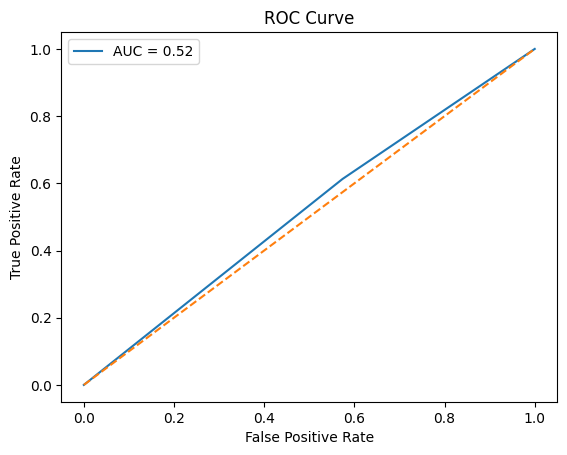

In [30]:
plt.figure()
plt.plot(fpr,tpr, label={f"AUC = {auc:.2f}"})
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Evaluating model's profitability (Out-of-sample)